In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, recall_score, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from joblib import dump, load

# Data preparing

In [36]:
cancer_data = pd.read_csv('../../data/cancer_data_v4.csv')
cancer_data.drop(['WBC', 'EO%', 'EO', 'GLO', 'NEUT%', 'HCT', 'TCH','TBIL', 'IBIL', 'LDH-L'], axis=1, inplace=True)
for fea in cancer_data.columns[6:]:
    median = cancer_data.groupby(['Age_group', 'A=male B=female'])[fea].median()
    cancer_data.set_index(['Age_group', 'A=male B=female'], inplace=True)
    cancer_data[fea].fillna(median, inplace=True)
    cancer_data.reset_index(inplace=True)
cancer_data['A=Case, B=Control'] = cancer_data['A=Case, B=Control'].apply(lambda x: 1 if x=='A' else 0)
X_train, X_test, y_train, y_test = train_test_split(cancer_data.drop(['Origin','Age_group','A=male B=female','ID', 'A=Case, B=Control', 'Pattern'], axis=1), cancer_data['A=Case, B=Control'], test_size=0.3, random_state=0)

# Random Forest

In [37]:
rf = load('../model/rf_clf')
y_pred = rf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

rf_prob = rf.predict_proba(X_test)[:,1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_prob)
rf_auc = auc(rf_fpr, rf_tpr)

print("ACC:",accuracy_score(y_test, y_pred))
print("REC:",recall_score(y_test, y_pred))
print("SPC:",tn/(tn+fp))
print("AUC:",rf_auc)
importances = pd.DataFrame(rf.feature_importances_, columns = ['rf_importance'], index=X_train.columns).sort_values(by='rf_importance', ascending=False)

ACC: 0.9414029084687767
REC: 0.9325657894736842
SPC: 0.9509803921568627
AUC: 0.9844820105075522


# XGBoost

In [30]:
xgb = load('../model/xgb_clf')
y_pred = xgb.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

xgb_prob = xgb.predict_proba(X_test)[:,1]
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_prob)
xgb_auc = auc(xgb_fpr, xgb_tpr)

print("ACC:",accuracy_score(y_test, y_pred))
print("REC:",recall_score(y_test, y_pred))
print("SPC:",tn/(tn+fp))
print("AUC:",xgb_auc)
importances['xgb_importance'] = pd.DataFrame(xgb.feature_importances_, index=X_train.columns)

ACC: 0.9820359281437125
REC: 0.9720394736842105
SPC: 0.9928698752228164
AUC: 0.9973899697438784


# ROC & AUC

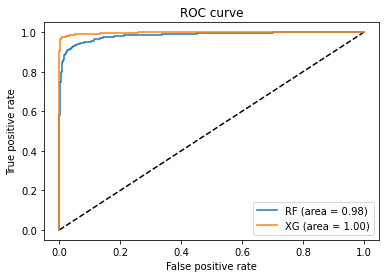

In [26]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(rf_fpr, rf_tpr, label='RF (area = %0.2f)' % rf_auc)
plt.plot(xgb_fpr, xgb_tpr, label='XG (area = %0.2f)' % xgb_auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# Data preparing2

In [38]:
cancer_data2 = pd.read_csv('../../data/cancer_data_v4.csv')
cancer_data2.drop(['WBC', 'EO%', 'EO', 'GLO', 'NEUT%', 'HCT', 'TCH','TBIL', 'IBIL', 'LDH-L'], axis=1, inplace=True)
for fea in cancer_data2.columns[6:]:
    median = cancer_data2.groupby(['Age_group', 'A=male B=female'])[fea].median()
    cancer_data2.set_index(['Age_group', 'A=male B=female'], inplace=True)
    cancer_data2[fea].fillna(median, inplace=True)
    cancer_data2.reset_index(inplace=True)
cancer_data2['A=Case, B=Control'] = cancer_data2['A=Case, B=Control'].apply(lambda x: 1 if x=='A' else 0)

group_b = cancer_data2[cancer_data2['Origin']=='B']
group_c = cancer_data2[cancer_data2['Origin']=='C'].sample(n=212)
new = pd.concat([group_b,group_c], axis=0).sample(frac=1,random_state=0)

X_train2, X_test2, y_train2, y_test2 = train_test_split(new.drop(['Origin','Age_group','A=male B=female','ID', 'A=Case, B=Control', 'Pattern'], axis=1), new['A=Case, B=Control'].sample(frac=1,random_state=0), test_size=0.2, random_state=0)

## RF

In [39]:
rf = load('../model/rf_clf_mini')
y_pred = rf.predict(X_test2)
tn, fp, fn, tp = confusion_matrix(y_test2, y_pred).ravel()

rf_prob = rf.predict_proba(X_test2)[:,1]
rf_fpr2, rf_tpr2, _ = roc_curve(y_test2, rf_prob)
rf_auc2 = auc(rf_fpr2, rf_tpr2)

print("ACC:",accuracy_score(y_test2, y_pred))
print("REC:",recall_score(y_test2, y_pred))
print("SPC:",tn/(tn+fp))
print("AUC:",rf_auc2)
importances['rf_mini_importance'] = pd.DataFrame(rf.feature_importances_, index=X_train2.columns)

ACC: 0.6352941176470588
REC: 0.6756756756756757
SPC: 0.6041666666666666
AUC: 0.7550675675675675


## XGB

In [40]:
xgb = load('../model/xgb_clf_mini')
y_pred = xgb.predict(X_test2)
tn, fp, fn, tp = confusion_matrix(y_test2, y_pred).ravel()

xgb_prob = xgb.predict_proba(X_test2)[:,1]
xgb_fpr2, xgb_tpr2, _ = roc_curve(y_test2, xgb_prob)
xgb_auc2 = auc(xgb_fpr2, xgb_tpr2)

print("ACC:",accuracy_score(y_test2, y_pred))
print("REC:",recall_score(y_test2, y_pred))
print("SPC:",tn/(tn+fp))
print("AUC:",xgb_auc2)
importances['xgb_mini_importance'] = pd.DataFrame(xgb.feature_importances_, index=X_train2.columns)

ACC: 0.788235294117647
REC: 0.7837837837837838
SPC: 0.7916666666666666
AUC: 0.8502252252252253


In [34]:
importances.to_csv('../../data/featureImportance.csv')

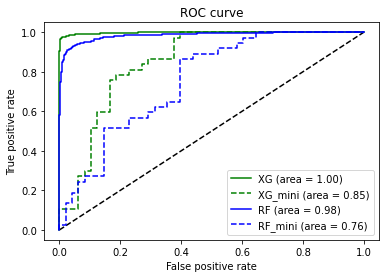

In [41]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(xgb_fpr, xgb_tpr, label='XG (area = %0.2f)' % xgb_auc, color='g')
plt.plot(xgb_fpr2, xgb_tpr2, label='XG_mini (area = %0.2f)' % xgb_auc2, color='g', linestyle="--")
plt.plot(rf_fpr, rf_tpr, label='RF (area = %0.2f)' % rf_auc, color='b')
plt.plot(rf_fpr2, rf_tpr2, label='RF_mini (area = %0.2f)' % rf_auc2, color='b', linestyle="--")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()